In [1]:
using DelimitedFiles
using Plots
pyplot()
# using NaNMath
using Statistics

In [2]:
nanmean(x) = mean(filter(!isnan, x))

nanmean (generic function with 1 method)

In [47]:
file = readdlm("exoplanet-data.txt");
t = file[:, 1];
light = file[:, 2];

In [48]:
#replacing NaNs with mean of 4 nearest points
for i in findall(isnan.(light))
    light[i] = nanmean(light[i-2:i+2])
end

# sanity check
print(sum(isnan.(light)))

0

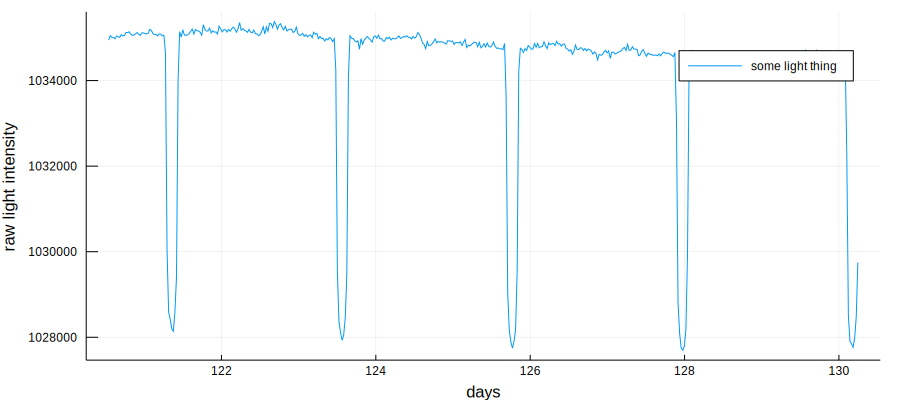

In [5]:
gr(size = (900, 400))
plot(t, light, label = "some light thing")

xlabel!("days")
ylabel!("raw light intensity")
# xlims!((125, 125.2))

# a) estimating orbital period of the planet

In [6]:
function flatsmooth(light, t, degree)
    lower = Int((degree-1)/2)
    upper = Int((degree+1)/2)
#     counter = 0
    l = length(light)
    lightsmoothed = zeros(l)
    
    for i in upper:length(light)-lower
        lightsmoothed[i] = mean(light[i-lower:i+lower])
    end
    
    for j in findall(lightsmoothed .== 0)
        lightsmoothed[j] = light[j]
    end
#     while counter < lower
#         t = deleteat!(deleteat!(t, length(t)), 1)
#         counter += 1
#     end
    return lightsmoothed, t
end

flatsmooth (generic function with 1 method)

In [12]:
plot(tsmooth3, lightsmooth3)

UndefVarError: UndefVarError: tsmooth3 not defined

In [61]:
a, b = flatsmooth(light, t, 7)

([1.03494e6, 1.03505e6, 1.03501e6, 1.03501e6, 1.03502e6, 1.03502e6, 1.03503e6, 1.03503e6, 1.03505e6, 1.03506e6  …  1.0333e6, 1.03236e6, 1.03142e6, 1.03047e6, 1.02954e6, 1.02868e6, 1.02832e6, 1.02799e6, 1.02848e6, 1.02975e6], [120.539, 120.559, 120.58, 120.6, 120.621, 120.641, 120.661, 120.682, 120.702, 120.723  …  130.061, 130.082, 130.102, 130.123, 130.143, 130.163, 130.184, 130.204, 130.225, 130.245])

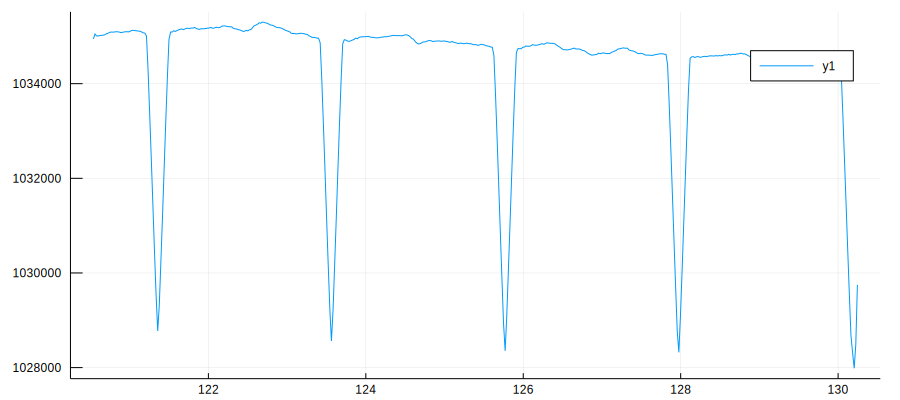

In [62]:
plot(b, a)

In [74]:
findmin(T)

(1.027985625e6, 474)

In [96]:
function prediction(Xtilde, weights)
    Y = 1034500*ones(size(Xtilde)[1])
    index = weights[1]
    while index < length(Y)
        Y[index] = 102800
        index += weights[2]
    end
    return Y
end

gradients(Xtilde, P, T) = 1/size(Xtilde)[1] * transpose(Xtilde) * (P - T)

function cost(Xtilde, P, T)
    array = P .- T
    cost = 1/(2*size(Xtilde)[1]) * array'array
end

cost (generic function with 1 method)

In [68]:
X = 1.0*t;
T = 1.0*a;
# drift = (maximum(T[findall(T.>1032000)])-minimum(T[findall(T.>1032000)]))/length(T)
# for i in 1:length(T)
#     T[i] += i*drift
# end

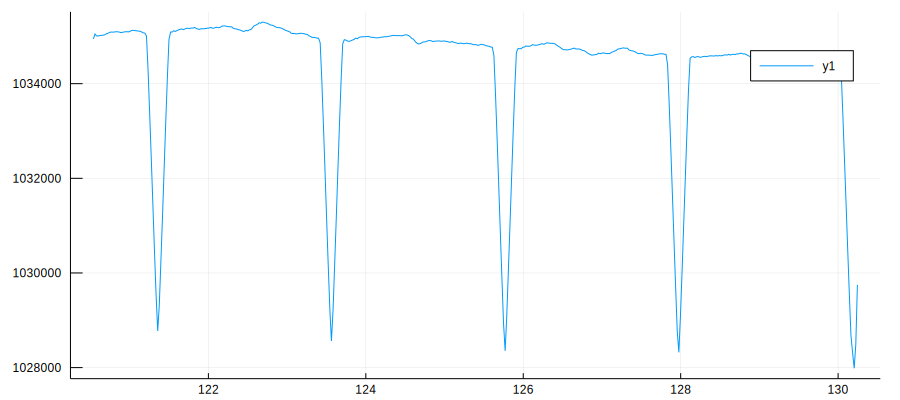

In [67]:
plot(X, T)

In [70]:
ns = length(T)
Xtilde = ones(ns, 2)
Xtilde[:, 1] = X

476-element Array{Float64,1}:
 120.53881583872862
 120.55925017884147
 120.57968441895355
 120.60011885905988
 120.62055319923093
 120.64098743934301
 120.66142177950678
 120.6818562196786 
 120.70229045979067
 120.72272479995445
 120.74315924018447
 120.76359348035476
 120.78402782051853
   ⋮               
 130.02034789774189
 130.04078223255783
 130.0612164672566 
 130.08165080194885
 130.10208523664915
 130.1225194712315 
 130.14295380580734
 130.1633882403912 
 130.18382257497433
 130.204256809433  
 130.2246911438997 
 130.24512557836715

In [103]:
nu = 100
C = zeros(nu)
w = [40, 100]

for i in 1:nu
    P = prediction(Xtilde, w)
    grads = gradients(Xtilde, P, T)
#     C[i] = cost(Xtilde, P, T)
    w = Int.(floor.(w-grads))
end

BoundsError: BoundsError: attempt to access 476-element Array{Float64,1} at index [-5370]

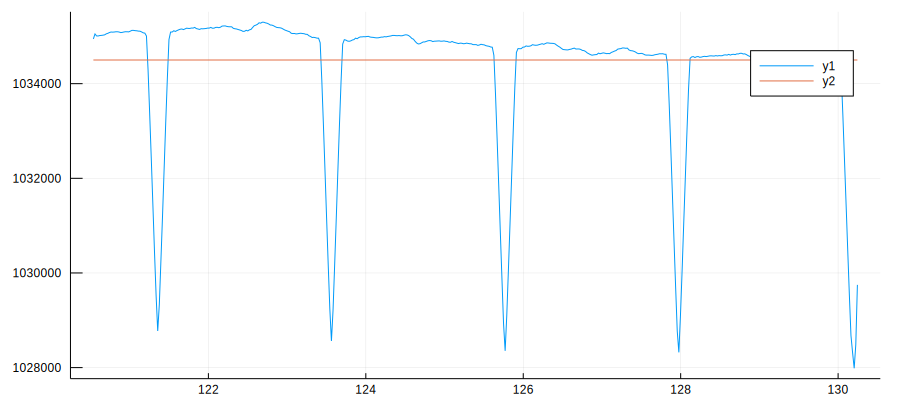

In [100]:
plot(X, T)
plot!(X, P)

In [101]:
P = prediction(Xtilde, w)

BoundsError: BoundsError: attempt to access 476-element Array{Float64,1} at index [-5370]

In [102]:
w

2-element Array{Int64,1}:
 -5370
   434

In [93]:
Y = 1034500*ones(size(Xtilde)[1])

476-element Array{Float64,1}:
 1.0345e6
 1.0345e6
 1.0345e6
 1.0345e6
 1.0345e6
 1.0345e6
 1.0345e6
 1.0345e6
 1.0345e6
 1.0345e6
 1.0345e6
 1.0345e6
 1.0345e6
 ⋮       
 1.0345e6
 1.0345e6
 1.0345e6
 1.0345e6
 1.0345e6
 1.0345e6
 1.0345e6
 1.0345e6
 1.0345e6
 1.0345e6
 1.0345e6
 1.0345e6

In [104]:
gradients(Xtilde, P, T)

2-element Array{Float64,1}:
 17867.492896047203  
   136.26056828981504